## Introduction

**Objective:**
To develop a model that can accurately predict the type of failure a machine might experience based on various operational parameters,
helping with preventative maintenance and reducing downtime.


**Key Steps:**
1. **Data Exploration:** Loads and examines the dataset, including checking for missing values, duplicates, class imbalance, and feature distributions.
2. **Data Preparation:**
    - Renames columns for clarity.
    - Removes redundant rows and unnecessary columns.
    - Preprocesses data by applying standardization to numeric features and one-hot encoding to categorical features.
3. **Model Building:**
    - Trains and evaluates several classification models (KNN, SVM, Random Forest, Gradient Boosting) to predict failure types.
    - Explores different strategies for handling class imbalance:
        - Assigning class weights
        - SMOTE
        - Hyperparameter tuning
4. **Evaluation:**
    - Uses classification reports and confusion matrices to assess the performance of the models.
    - Provides visualizations for understanding the model predictions and the distribution of failure types.


## About Data

- This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points.
- **Column Discription**
  - **UID:** unique identifier ranging from 1 to 10000.
  - **product ID:** consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number.
  - **type:** just the product type L, M or H from column 2.
  - **air temperature [K]:** generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.
  - **process temperature [K]:** generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
  - **rotational speed [rpm]:** calculated from a power of 2860 W, overlaid with a normally distributed noise.
  - **torque [Nm]:** torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
  - **tool wear [min]:** The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
  - a '**Failure Type**' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.
    - **Tool wear failure (TWF):** the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
    - **Heat dissipation failure (HDF):** heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
    - **Power failure (PWF):** the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
    - **Overstrain failure (OSF):** if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
    - **Random failures (RNF):** each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.
- **This dataset is part of the following publication.**
  - S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

**Image of the milling process**
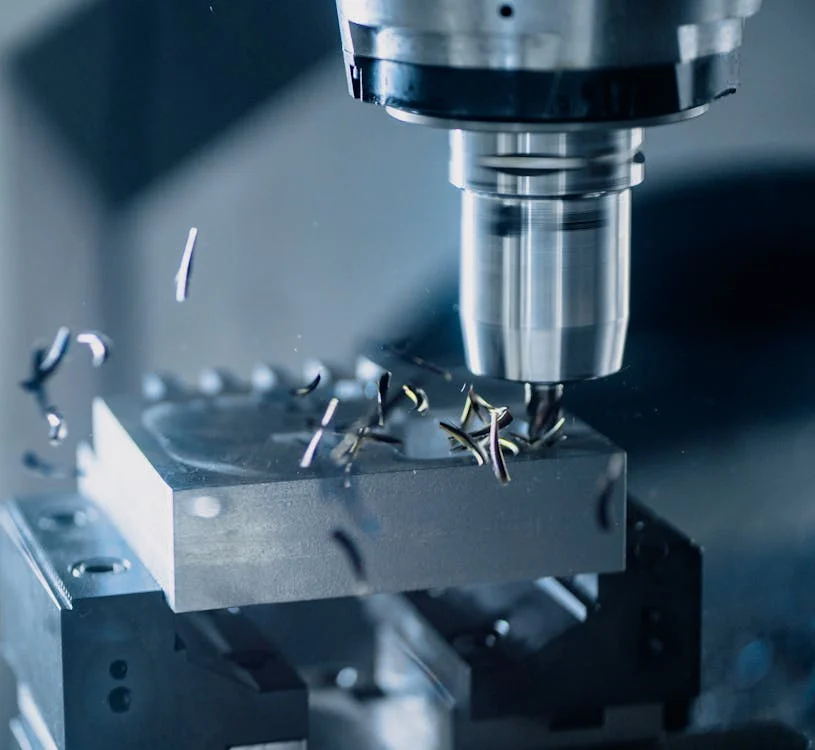

## Importing the necessary libraries

In [1]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#ignore feature warning
import warnings
warnings.filterwarnings('ignore')

#Resampling
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

**Observation:**

- The warnings module suppresses warning messages during code execution to keep the output clean.
- ColumnTransformer from sklearn.compose applies different preprocessing steps to specific columns of a dataset, allowing for customized data transformations.

- Pipeline from sklearn.pipeline enables the sequential application of data processing and modeling steps, simplifying the workflow and ensuring consistent execution of all steps.






##Exploratory data analysis

**Upload DataFrame as df**

In [2]:
df =pd.read_csv(r"D:\ml projects\failures_data.csv")
df

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  \
0                       1551         42.8                0       0   
1                       1408         46.3                3       0   
2                       1498         49.4                5       0   
3                       1433         39.5                7       0   
4                       1408         40.0                9       0   
...                      ...          ...              ...     ...   
9995                    1604         29.5               14       0   
9996                    1632         31.8               17       0   
9997                    1645         33.4               22       0   
9998                    1408         48.5               25       0   
9999                    1500         40.2               30       0   

     Failure Type  
0      No Failure  
1      No Failure  
2      No Failure  
3      No Failure  
4      No Failure  
...           ...  
9995   No Failure  
9996   No Failure  
9997   No Failure  
9998   No Failure  
9999   No Failure  

[10000 rows x 10 columns]

**Check the data for duplicate values**

In [3]:
df.duplicated().sum()

0

**Check the data for missing values**

In [4]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

**Data structure**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [6]:
df.describe()

UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000      0.000000  
25%               1423.000000     33.200000        53.000000      0.000000  
50%               1503.000000     40.100000       108.000000      0.000000  
75%               1612.000000     46.800000       162.000000      0.000000  
max               2886.000000     76.600000       253.000000      1.000000

**Check the data for class imbalance**

In [7]:
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

**Observations:**

*   The dataset shows significant class imbalance, with "No Failure" dominating at 9,652 instances, while other failure types are much less frequent (e.g., Heat Dissipation Failure: 112, Power Failure: 95). This imbalance can lead to biased model performance, making it essential to address for more accurate predictions across all classes.



## Data preparation

**Rename the columns**

In [8]:
rename_columns = {
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'
}
df.rename(rename_columns, axis = 1, inplace = True)

**Note:**
- I renamed the column to make it easier to work with.

**Identify redundant rows**

In [9]:
from itertools import count
count_failures = (df['Target'] == 1).sum()
print('Number of failures:', count_failures)

sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print('Number of failures considering both "Failure_type" & "Target":', sum_failures)

count_redundant_rows = count_failures - sum_failures
print('Number of redundant rows:', count_redundant_rows)

Number of failures: 339
Number of failures considering both "Failure_type" & "Target": 330
Number of redundant rows: 9


**Observations:**
- 9 rows are removed because their Failure_type is "No Failure" but still their target class is 1.

**Remove redundant rows/col**

In [10]:
rows_to_remove = df[(df['Target'] == 1) & (df['Failure_type'] == 'No Failure')]
df.drop(rows_to_remove.index, inplace=True)

**Removing unnecessary columns**

In [11]:
drop_columns = ["ID", "Product_ID", "Target"]
df.drop(drop_columns, axis = 1, inplace = True)

**Observations:**
- "ID" & "Product_ID" are categorical variables and are of no use.
- "Target" is removed because we want to keep Failure_type as target.

**Removing "Random Failures" from the "Failure_type" column.**

In [12]:
df = df.loc[df['Failure_type'] != 'Random Failures']

**Observations:**

*   I have removed the Random Failures samples as they are random and can't be generalised.



**Renaming the data points in type column**

In [13]:
rename_type = {
    'L':'Low',
    'M':'Medium',
    'H':'High'
}
df['Type'].replace(rename_type, inplace = True)

**Plot “Type” distribution**

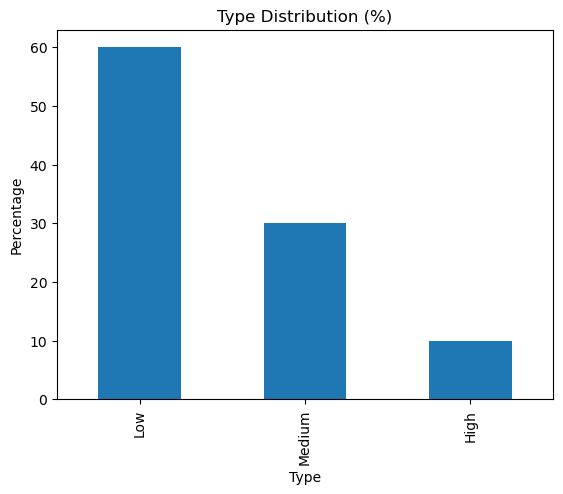

In [14]:
type_percentage = df['Type'].value_counts(normalize=True) * 100
type_percentage.plot(kind='bar', title='Type Distribution (%)')
plt.ylabel('Percentage')
plt.show()

**Plot “Failure_type” distribution**

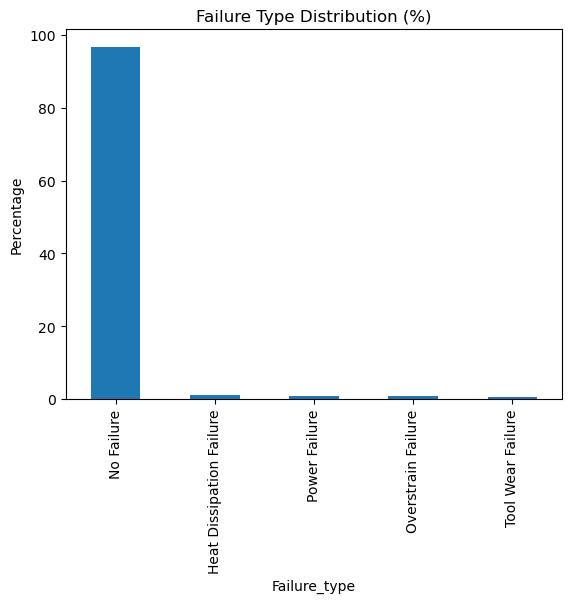

In [15]:
failure_percentage = df['Failure_type'].value_counts(normalize=True) * 100
failure_percentage.plot(kind='bar', title='Failure Type Distribution (%)')
plt.ylabel('Percentage')
plt.show()

**Observations:**
- This graph clearly shows that the dataset is highly imbalance.

**Plot histogram and boxplot of numeric features**

In [16]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

**Observations:**
- I have created a separate list of numeric and categorical features so that we can easily carry transformations on them.

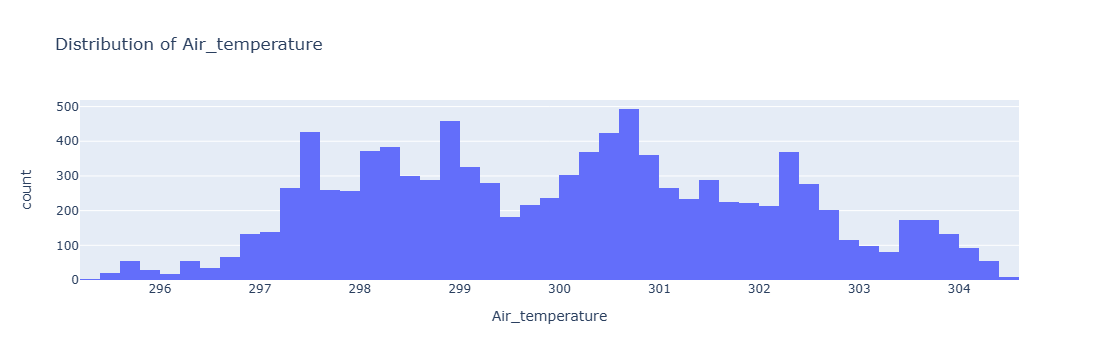

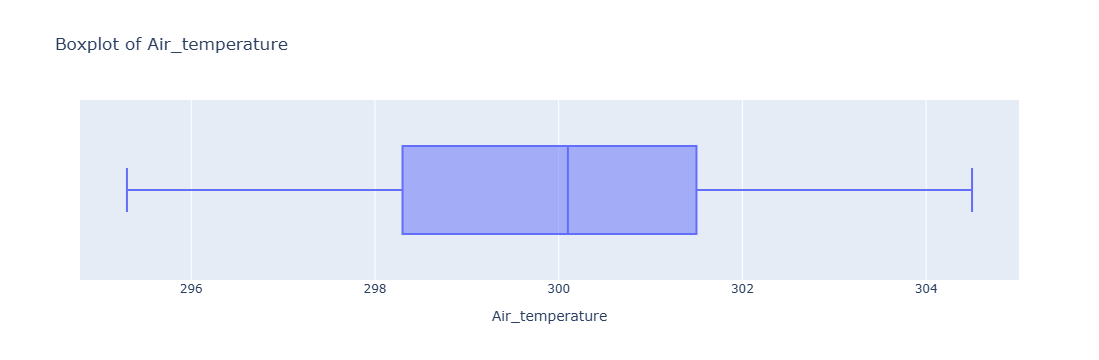

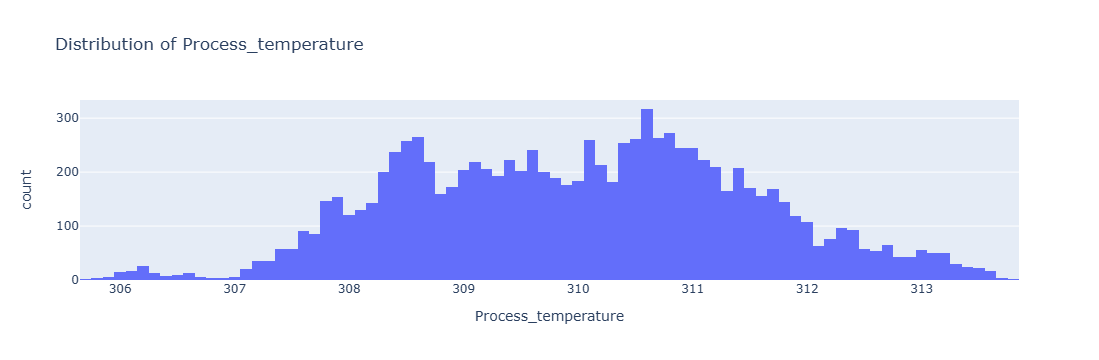

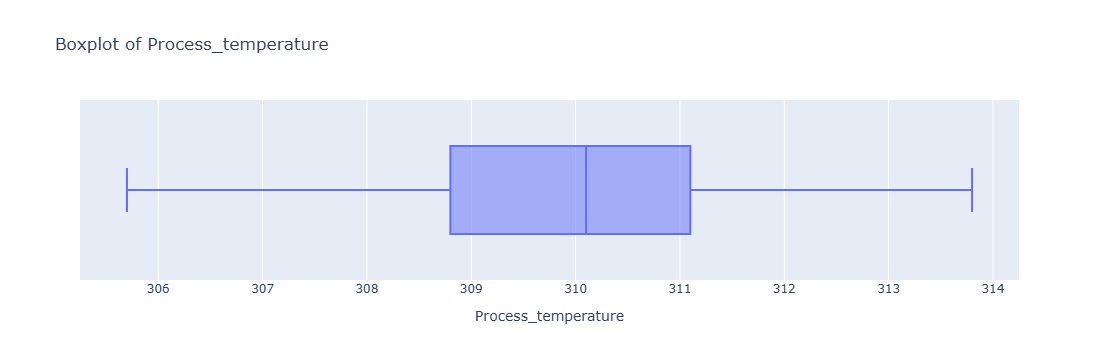

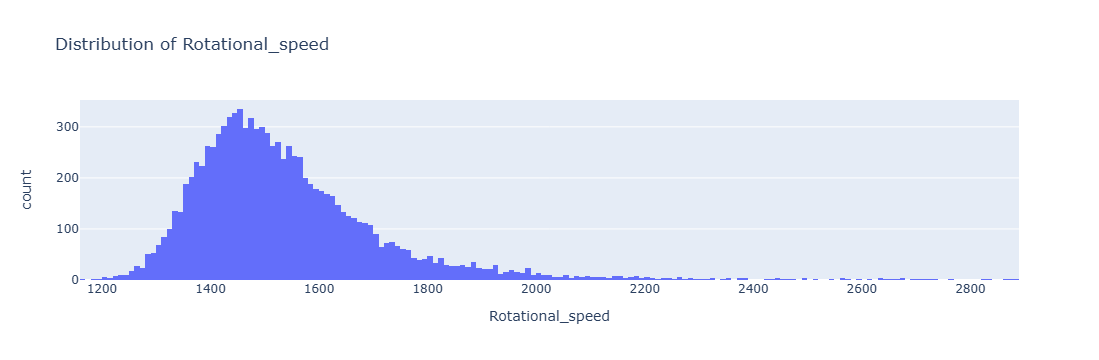

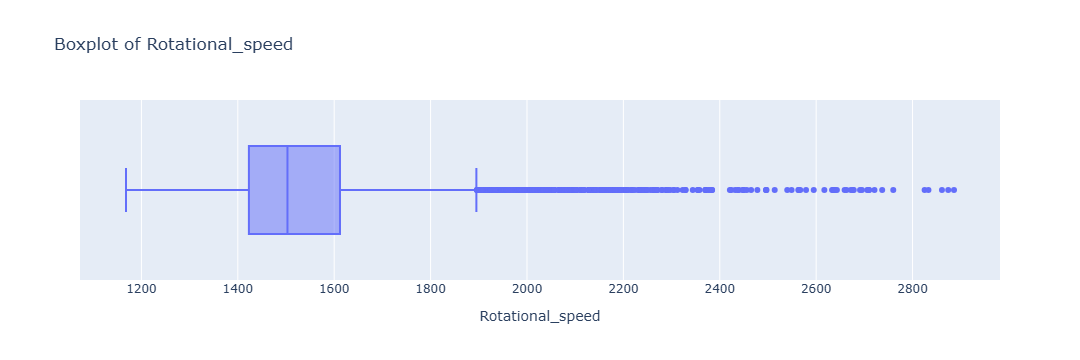

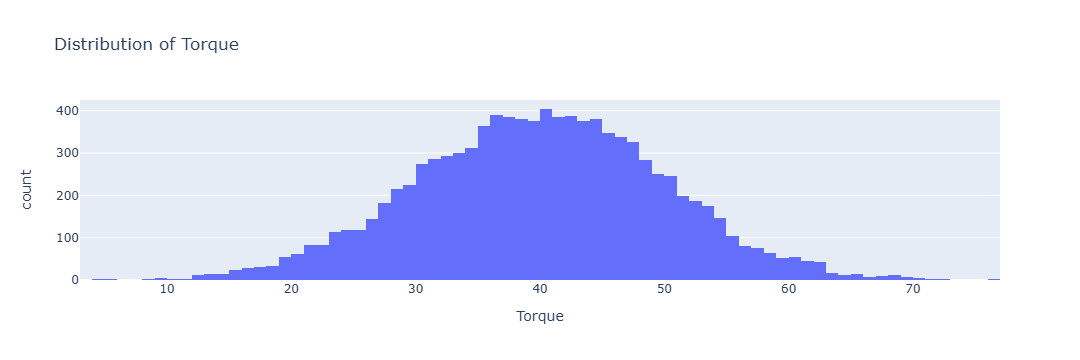

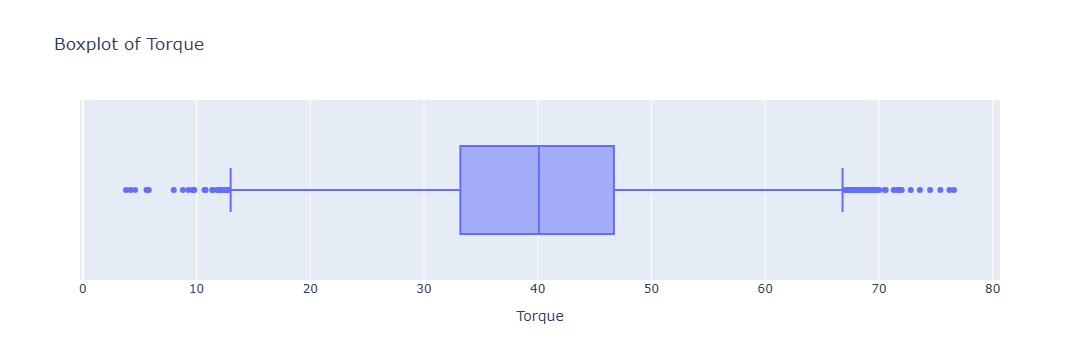

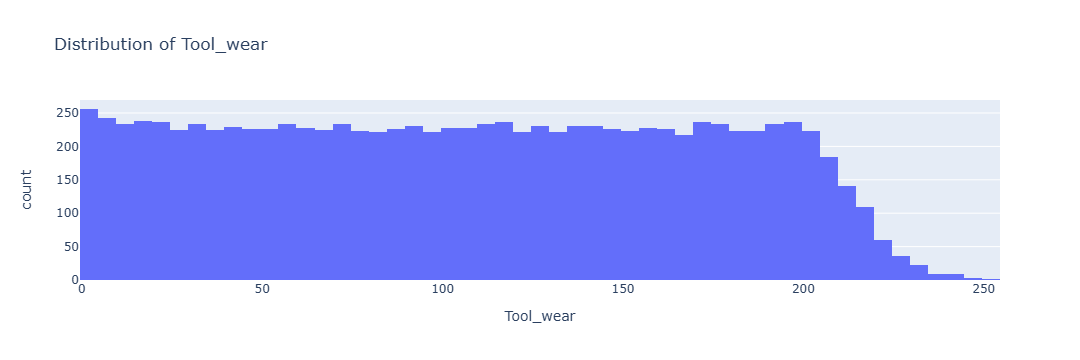

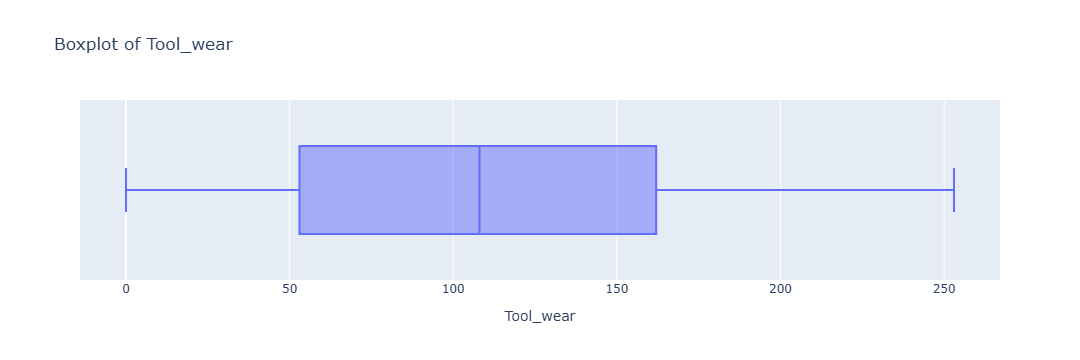

In [17]:
for feature in NUMERIC_FEATURES:
  fig = px.histogram(df, x=feature, title=f'Distribution of {feature}')
  fig.show()

  fig = px.box(df, x=feature, title=f'Boxplot of {feature}')
  fig.show()

**Observations:**
- **Air temperature:**
  - The distribution of air temperature appears roughly normal, with a slight skew towards the lower values.
- **Process temperature:**
  - The process temperature also exhibits a nearly normal distribution.
- **Rotational speed:**
  - The distribution of rotational speed has a slight skew towards the higher values.
  - There are outliers on the higher end of the distribution, suggesting some instances of high rotational speeds.
- **Torque:**
  - The distribution of torque appears to be normal.
  - The boxplot reveals a few outliers at both the ends.
- **Tool wear:**
  - Tool wear demonstrates a right-skewed distribution, with a longer tail towards higher wear values.


**Distribution of failure types out of total failure**

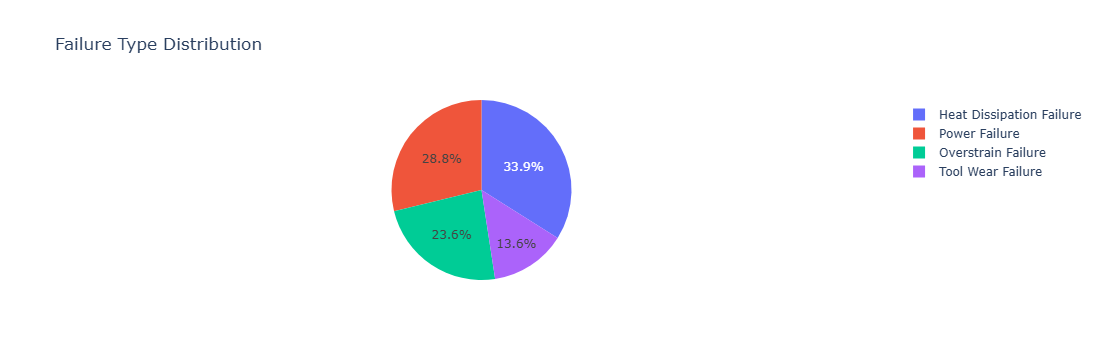

In [18]:
df_failure_type = df.loc[df['Failure_type'] != "No Failure"]
proportions = df_failure_type['Failure_type'].value_counts(normalize=True)
px.pie(names=proportions.index, values=proportions.values, title='Failure Type Distribution')

**Observations:**
- The pie chart visualizes the proportion of different failure types among the instances that experienced failures (excluding "No Failure").
- It provides a clear overview of the relative frequency of each failure type within the subset of the data where failures occurred.
- This chart can be useful for understanding the prevalence of different types of failures and potentially identifying the most common failure modes.

**Plot correlation and heatmap of numeric features**

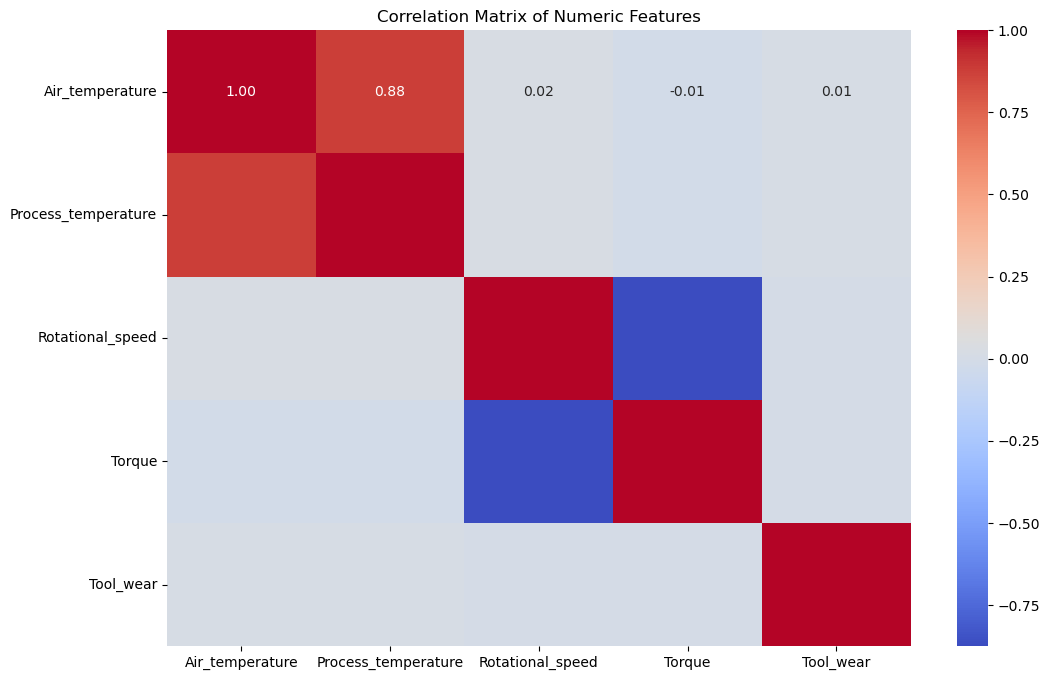

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[NUMERIC_FEATURES].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

**Observations:**
- The heatmap shows the correlation between different numeric features.
- Process temperature and air temperature are highly correlated (0.8).
- Rotational speed and torque are negatively correlated (-0.83).
- Tool wear is weakly correlated with other features.

**Scale numeric features and apply OneHotEncoder for categoric features**

In [20]:
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, NUMERIC_FEATURES),
    ('cat_trans', cat_pipeline, CATEGORIC_FEATURES)
])

df_transformed = preprocessor.fit_transform(df)

encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(CATEGORIC_FEATURES)
new_column_names = list(NUMERIC_FEATURES) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head(3)

Air_temperature  Process_temperature  Rotational_speed    Torque  \
0        -0.951417            -0.946356          0.067484  0.283054   
1        -0.901428            -0.878954         -0.729604  0.634238   
2        -0.951417            -1.013759         -0.227940  0.945286   

   Tool_wear  Type_High  Type_Low  Type_Medium  
0  -1.695647        0.0       0.0          1.0  
1  -1.648511        0.0       1.0          0.0  
2  -1.617087        0.0       1.0          0.0

**Observations:**
- This code cell is crucial for preparing the dataset for machine learning.
- It applies StandardScaler to numeric features, which ensures that all numeric features have a mean of 0 and a standard deviation of 1. This process helps prevent features with larger values from dominating the model's training.
- It uses OneHotEncoder to transform categorical variables into numerical representations by creating binary columns for each unique category. This step allows machine learning models to understand and utilize categorical features effectively.


##Model building

1. KNN for classification

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.45      0.22      0.29        23
              No Failure       0.98      1.00      0.99      1936
      Overstrain Failure       0.50      0.50      0.50         8
           Power Failure       1.00      0.39      0.56        23
       Tool Wear Failure       0.00      0.00      0.00         5

                accuracy                           0.97      1995
               macro avg       0.59      0.42      0.47      1995
            weighted avg       0.97      0.97      0.97      1995



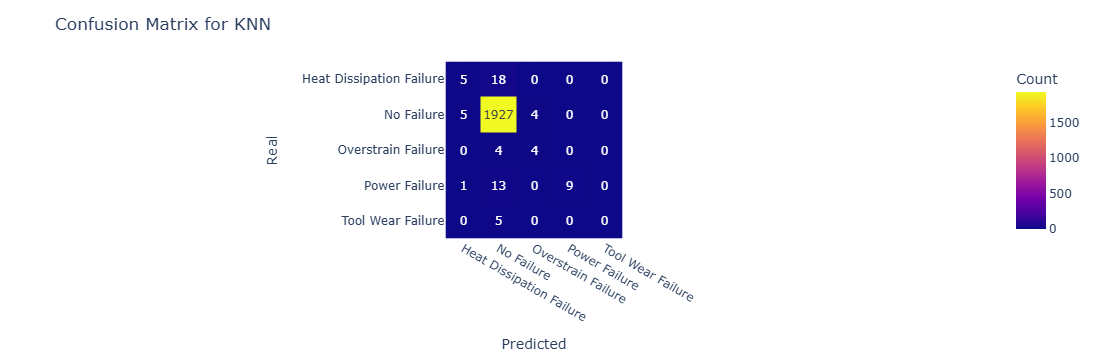

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Define X and y
X = df_transformed
y = df['Failure_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using Plotly
fig = px.imshow(cm,
                labels=dict(x="Predicted", y="Real", color="Count"),
                x=list(np.unique(y)),
                y=list(np.unique(y)),
                text_auto=True)
fig.update_layout(title='Confusion Matrix for KNN')
fig.show()

2. SVM for classification

                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      0.04      0.08        23
              No Failure       0.98      1.00      0.99      1936
      Overstrain Failure       0.67      0.50      0.57         8
           Power Failure       1.00      0.48      0.65        23
       Tool Wear Failure       0.00      0.00      0.00         5

                accuracy                           0.98      1995
               macro avg       0.73      0.40      0.46      1995
            weighted avg       0.98      0.98      0.97      1995



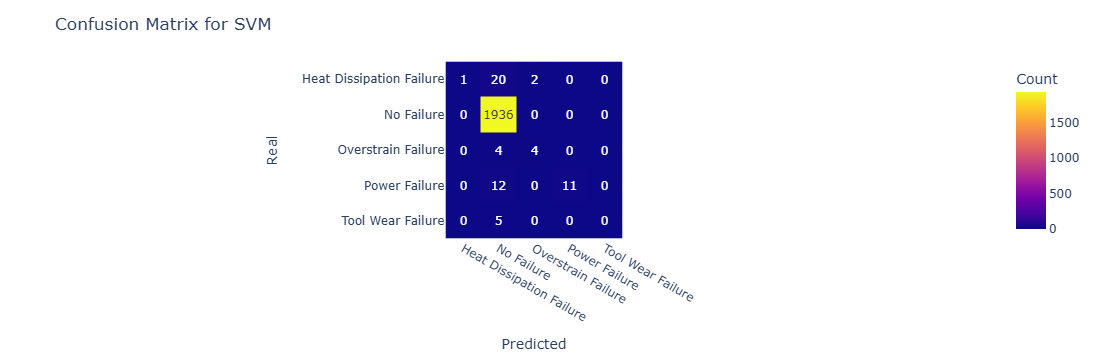

In [22]:
from sklearn.svm import SVC

# Define X and y
X = df_transformed
y = df['Failure_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the SVM model
svm = SVC()
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using Plotly
fig = px.imshow(cm,
                labels=dict(x="Predicted", y="Real", color="Count"),
                x=list(np.unique(y)),
                y=list(np.unique(y)),
                text_auto=True)
fig.update_layout(title='Confusion Matrix for SVM')
fig.show()

3. Random forest for classification

                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      0.48      0.65        23
              No Failure       0.99      1.00      0.99      1936
      Overstrain Failure       0.67      0.75      0.71         8
           Power Failure       0.88      0.61      0.72        23
       Tool Wear Failure       0.00      0.00      0.00         5

                accuracy                           0.98      1995
               macro avg       0.71      0.57      0.61      1995
            weighted avg       0.98      0.98      0.98      1995



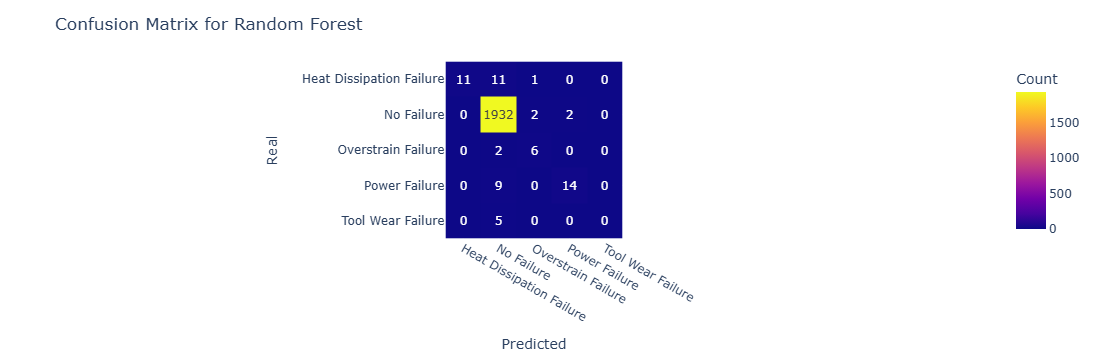

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Define X and y
X = df_transformed
y = df['Failure_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using Plotly
fig = px.imshow(cm,
                labels=dict(x="Predicted", y="Real", color="Count"),
                x=list(np.unique(y)),
                y=list(np.unique(y)),
                text_auto=True)
fig.update_layout(title='Confusion Matrix for Random Forest')
fig.show()

4. Gradient boosting for classification

4.1 Gradient boosting without any tuning

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.95      0.83      0.88        23
              No Failure       0.99      1.00      0.99      1936
      Overstrain Failure       0.54      0.88      0.67         8
           Power Failure       0.95      0.83      0.88        23
       Tool Wear Failure       0.00      0.00      0.00         5

                accuracy                           0.99      1995
               macro avg       0.69      0.70      0.69      1995
            weighted avg       0.99      0.99      0.99      1995



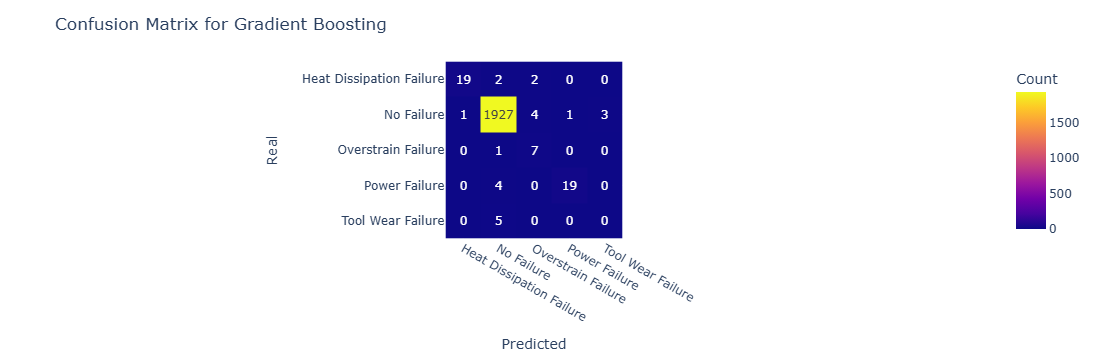

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

# Define X and y
X = df_transformed
y = df['Failure_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Gradient Boosting model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using Plotly
fig = px.imshow(cm,
                labels=dict(x="Predicted", y="Real", color="Count"),
                x=list(np.unique(y)),
                y=list(np.unique(y)),
                text_auto=True)
fig.update_layout(title='Confusion Matrix for Gradient Boosting')
fig.show()

4.2 Gradient boosting with weighted class

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.73      0.96      0.83        23
              No Failure       1.00      0.95      0.97      1936
      Overstrain Failure       0.35      1.00      0.52         8
           Power Failure       0.67      0.87      0.75        23
       Tool Wear Failure       0.03      0.40      0.06         5

                accuracy                           0.95      1995
               macro avg       0.56      0.84      0.63      1995
            weighted avg       0.98      0.95      0.97      1995



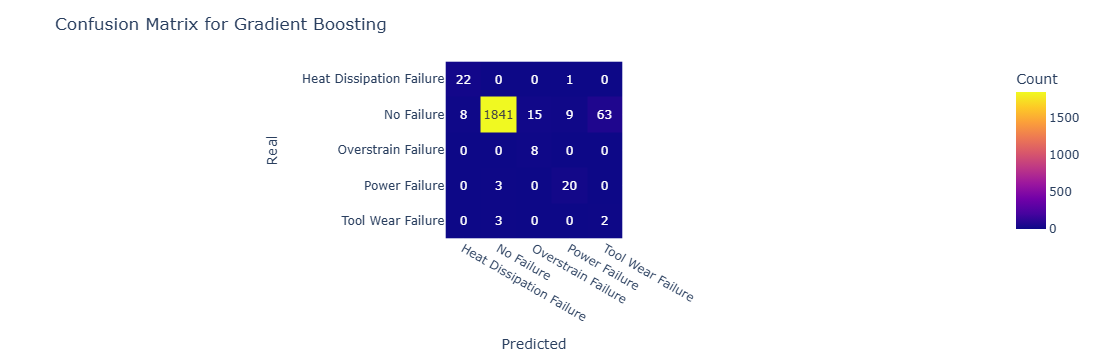

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

# Define X and y
X = df_transformed
y = df['Failure_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary mapping class labels to their weights
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train, sample_weight=class_weight.compute_sample_weight(class_weight_dict, y_train))

# Make predictions on the test set
y_pred = gb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using Plotly
fig = px.imshow(cm,
                labels=dict(x="Predicted", y="Real", color="Count"),
                x=list(np.unique(y)),
                y=list(np.unique(y)),
                text_auto=True)
fig.update_layout(title='Confusion Matrix for Gradient Boosting')
fig.show()

4.3 Gradient boosting with SMOTE

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.76      0.96      0.85        23
              No Failure       1.00      0.95      0.97      1936
      Overstrain Failure       0.32      1.00      0.48         8
           Power Failure       0.60      0.91      0.72        23
       Tool Wear Failure       0.04      0.60      0.08         5

                accuracy                           0.95      1995
               macro avg       0.54      0.88      0.62      1995
            weighted avg       0.98      0.95      0.96      1995



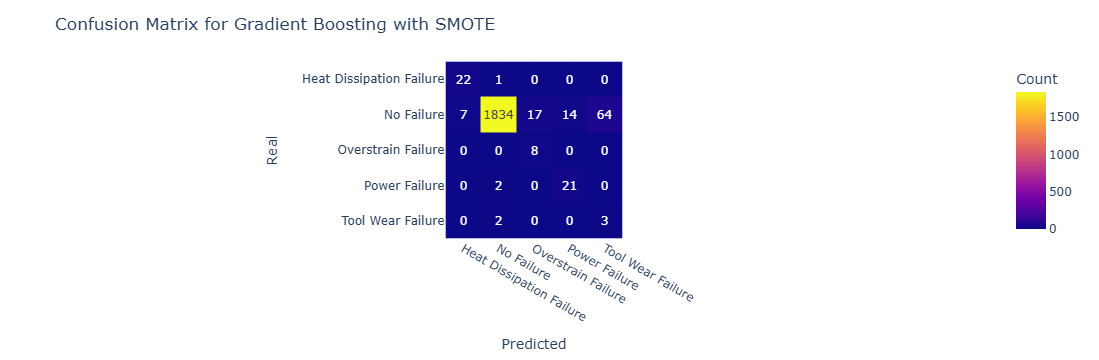

In [26]:
# Define X and y
X = df_transformed
y = df['Failure_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

gb = GradientBoostingClassifier()
gb.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = gb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using Plotly
fig = px.imshow(cm,
                labels=dict(x="Predicted", y="Real", color="Count"),
                x=list(np.unique(y)),
                y=list(np.unique(y)),
                text_auto=True)
fig.update_layout(title='Confusion Matrix for Gradient Boosting with SMOTE')
fig.show()

4.4.1 Gradient boosting - hyperparameter tuning using gridsearch

In [28]:
from sklearn.model_selection import GridSearchCV

# Define X and y
X = df_transformed
y = df['Failure_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary mapping class labels to their weights
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GradientBoostingClassifier model
gb = GradientBoostingClassifier()

# Perform GridSearchCV to find the best parameters optimized for recall
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, scoring='recall_macro', n_jobs=1, verbose=2)

grid_search.fit(X_train, y_train, sample_weight=class_weight.compute_sample_weight(class_weight_dict, y_train))

# Print the best parameters
print("Best parameters found by GridSearchCV: ", grid_search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=3

**Note:**
- This code was executed on powerful Lab PC to find the optimum values of hyperparameter using Gridsearch CV.

4.4.2 Gradient boosting with optimized parameters

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.32      0.91      0.47        23
              No Failure       1.00      0.88      0.93      1936
      Overstrain Failure       0.18      0.88      0.30         8
           Power Failure       0.37      1.00      0.53        23
       Tool Wear Failure       0.04      1.00      0.07         5

                accuracy                           0.88      1995
               macro avg       0.38      0.93      0.46      1995
            weighted avg       0.98      0.88      0.92      1995



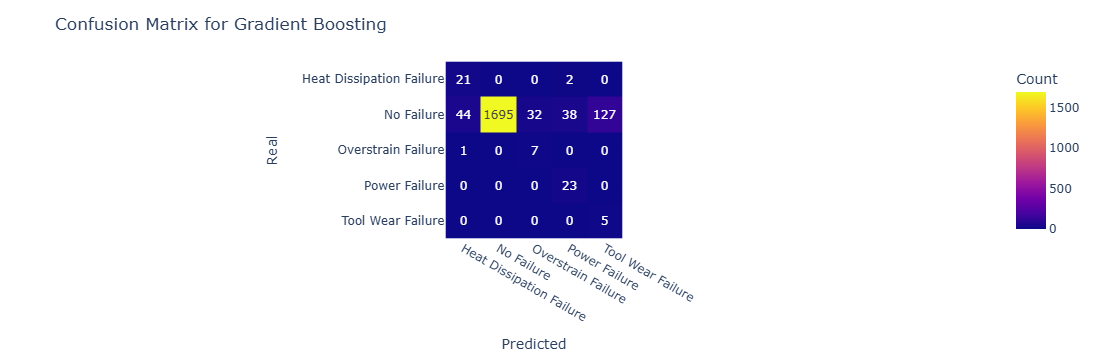

In [29]:
# Define X and y
X = df_transformed
y = df['Failure_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary mapping class labels to their weights
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Create and train the Gradient Boosting model with specified parameters
gb = GradientBoostingClassifier(
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=200
)

# Fit the model with sample weights
gb.fit(X_train, y_train, sample_weight=class_weight.compute_sample_weight(class_weight_dict, y_train))

# Make predictions on the test set
y_pred = gb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using Plotly
fig = px.imshow(cm,
                labels=dict(x="Predicted", y="Real", color="Count"),
                x=list(np.unique(y)),
                y=list(np.unique(y)),
                text_auto=True)
fig.update_layout(title='Confusion Matrix for Gradient Boosting')
fig.show()

## Conclusion

The task was to predict different types of machine failures, a critical real-world problem where accurate predictions can significantly reduce downtime and maintenance costs. Throughout the project, we explored various machine learning models to understand their strengths and weaknesses. Simpler models like K-Nearest Neighbors (KNN) and Support Vector Classifier (SVC) performed poorly, with macro average recalls of 0.42 and 0.40, respectively, as they struggled with the class imbalance and failed to capture key patterns in the minority class. Random Forest showed some improvement with a recall of 0.56 but still faced limitations.

However, Gradient Boosting (GB) demonstrated its strength, achieving a recall of 0.70 without tuning. By applying weighted classes and SMOTE to handle the imbalance, GB's performance further improved, reaching recalls of 0.84 and 0.88. Finally, after optimizing the parameters, the macro average recall increased to an impressive 0.93. This high recall is crucial in real-life scenarios, as it ensures accurate identification of all types of machine failures, including rare ones, minimizing potential disruptions and improving maintenance strategies. This project highlighted the importance of using advanced models like Gradient Boosting for such critical tasks, and it provided us with a deeper understanding of how different models perform under varying conditions.